In [1]:
from collections import OrderedDict

from IPython.display import display, Javascript
from ipywidgets import interactive, Select, HBox

import pandas as pd
import numpy as np

In [2]:
OBS_DF = pd.read_csv('/Users/myliu/local/notebooks/PyCon/PyCon_MinT_obs_2015-2016.csv')
OBS_DF = OBS_DF.query('station_number == {} and season == "{}"'
                      .format(86338, 'Winter 2015'))
OBS_DF = OBS_DF.set_index(['valid_15z_date'])

FCST_DF = pd.read_csv('/Users/myliu/local/notebooks/PyCon/PyCon_MinT_fcst_2015-2016.csv')
FCST_DF = FCST_DF.query('station_number == {} and season == "{}"'
                        .format(86338, 'Winter 2015'))
FCST_DF = FCST_DF.set_index(['valid_15z_date'])

In [3]:
# plot boundaries
_MIN_T = -10
_MAX_T = 40

<IPython.core.display.Javascript object>


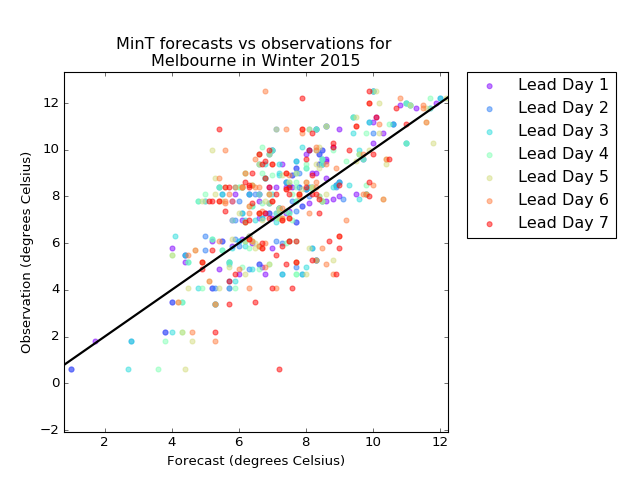

In [4]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib notebook    

def plot_mpl(**kwargs):

    fig = plt.figure()
    ax = fig.add_axes([0.1, 0.1, 0.6, 0.75])

    lead_days = FCST_DF['lead_day'].unique()
    colors = iter(cm.rainbow(np.linspace(0, 1, len(lead_days))))

    y = OBS_DF['MinT']

    for lead_day in lead_days:
        x = FCST_DF.query('lead_day == {}'.format(lead_day))['MinT']
        plt.scatter(x, y, 
                    color=next(colors), alpha=0.5, 
                    label='Lead Day {}'.format(lead_day))

    plt.plot([_MIN_T, _MAX_T], [_MIN_T, _MAX_T], 'k-', lw=2)

    ax.set_xlim([_MIN_T, _MAX_T])
    ax.set_ylim([_MIN_T, _MAX_T])

    ax.set_xlabel('Forecast (degrees Celsius)')
    ax.set_ylabel('Observation (degrees Celsius)')

    plt.title('MinT forecasts vs observations for \nMelbourne in Winter 2015')

    plt.legend(scatterpoints=1, 
               bbox_to_anchor=(1.05, 1), 
               loc=2, 
               borderaxespad=0.)

plot_mpl()

In [5]:
import bokeh
from bokeh.plotting import show
from bokeh.models import ColumnDataSource, Range1d, glyphs
from bokeh.charts import Scatter
from bokeh.io import output_notebook
from bokeh.resources import INLINE

output_notebook(resources=INLINE)

def plot_bokeh(**kwargs):
    
    tools = 'hover,resize,pan,wheel_zoom,box_zoom,reset,tap,previewsave,box_select'   

    y = OBS_DF['MinT']
        
    data = pd.DataFrame(columns=[
        'Observation (degrees Celsius)',
        'Forecast (degrees Celsius)',
        'Lead Day'
    ])

    for lead_day in FCST_DF['lead_day'].unique():
        x = FCST_DF.query('lead_day == {}'.format(lead_day))['MinT']

        curr_lead_day = pd.DataFrame()
        curr_lead_day['Forecast (degrees Celsius)'] = x        
        curr_lead_day['Observation (degrees Celsius)'] = y
        curr_lead_day['Lead Day'] = 'Lead Day {}'.format(lead_day)
        data = pd.concat([data, curr_lead_day], ignore_index=True)
        
    fig = Scatter(
        data,
        x='Forecast (degrees Celsius)',
        y='Observation (degrees Celsius)',
        color='Lead Day',
        legend='top_right',
        title='MinT forecasts vs observations for Melbourne in Winter 2015',
        tools=tools
    )

    # Add a line for y=x
    fig.add_glyph(
        ColumnDataSource(
            {'x': [_MIN_T, _MAX_T],
             'y': [_MIN_T, _MAX_T]}),
        glyphs.Line(x='x', y='y', line_width=2, line_color='black')
    )
    
    fig.set(
        x_range=Range1d(_MIN_T, _MAX_T),
        y_range=Range1d(_MIN_T, _MAX_T),
    )

    show(fig)
    
plot_bokeh()

Loading BokehJS ...

In [15]:
import plotly
from plotly import graph_objs as go
from plotly.offline import init_notebook_mode, plot, iplot
init_notebook_mode(connected=False)

def plot_plotly(**kwargs):
    
    y = OBS_DF['MinT']
    
    data = []
    for lead_day in FCST_DF['lead_day'].unique():
        x = FCST_DF.query('lead_day == {}'.format(lead_day))['MinT']
                
        trace = go.Scatter(x=x, y=y,
                           mode='markers',
                           name="Lead Day {}".format(lead_day))
        data.append(trace)
    
    ideal = go.Scatter(x=[_MIN_T, _MAX_T], y=[_MIN_T, _MAX_T],
                       mode='lines', showlegend=False,
                       hoverinfo='none')
    data.append(ideal)
    
    layout = go.Layout(
        width=600, height=600, 
        title='MinT forecasts vs observations for Melbourne in Winter 2015',
        xaxis={'title': 'Forecast (degrees Celsius)',
               'range': [_MIN_T, _MAX_T],
               'gridcolor': '#BBBBBB', 'gridwidth': 1},  # high contrast gridlines
        yaxis={'title': 'Observation (degrees Celsius)',
               'range': [_MIN_T, _MAX_T],
               'gridcolor': '#BBBBBB', 'gridwidth': 1})  # high contrast gridlines

    figure = go.Figure(data=data, layout=layout)
    iplot(figure, show_link=False)
    
plot_plotly()

In [16]:
PLOT_METHODS = OrderedDict([
    ('matplotlib', plot_mpl),
    ('bokeh', plot_bokeh),
    ('plotly', plot_plotly)
])

PLOT_METHOD_WIDGET = Select(options=list(PLOT_METHODS.keys()),
                            description='Plotting method')

def plot_scatter(**kwargs):
    plot_method = PLOT_METHOD_WIDGET.value
    PLOT_METHODS[plot_method]()

interactive(plot_scatter, plot_method=PLOT_METHOD_WIDGET)